Import modules and packages

Run this code in the qiime2-2022.8 environment

In [1]:
get_ipython().run_line_magic('matplotlib', 'inline')
import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
import seaborn
import argparse
import pathlib
from os.path import join, exists
from tax_credit.plotting_functions import (pointplot_from_data_frame,
                                           boxplot_from_data_frame,
                                           heatmap_from_data_frame,
                                           per_level_kruskal_wallis,
                                           beta_diversity_pcoa,
                                           average_distance_boxplots,
                                           rank_optimized_method_performance_by_dataset)
from tax_credit.eval_framework import (evaluate_results,
                                       method_by_dataset_a1,
                                       parameter_comparisons,
                                       merge_expected_and_observed_tables,
                                       filter_df)

In [5]:
def evaluate_method_accuracy(database_name,outdir):
    expected_results_dir = join("data/precomputed-results/", "mock-community")
    mock_results_fp = join(expected_results_dir, 'mock_results.tsv')
    results_dirs = [expected_results_dir]
    mock_dir = join("data", "mock-community")
    if not os.path.exists(outdir):
        os.makedirs(outdir)

    dataset_ids = ['mock-1', 'mock-2']
    method_ids = ['naive-bayes', 'naive-bayes-bespoke']
    #dataset_ids = ['mock-1', 'mock-2', 'mock-3', 'mock-4', 'mock-5','mock-6', 'mock-7', 'mock-8','mock-12','mock-13','mock-14', 'mock-15',       'mock-16','mock-18', 'mock-19', 'mock-20', 'mock-21', 'mock-22']
    #method_ids = ['q2-NB', 'q2-SFM-RF', 'q2-SFM-SGD','q2-SFM-NB']
    ref_ids = [database_name]
    # Find mock community pre-computed tables, expected tables, and "query" tables
    # Note: if you have added additional methods to add, set append=True. If you are attempting to recompute pre-computed results, set           force=True.
    mock_results = evaluate_results(results_dirs, 
                                expected_results_dir, 
                                mock_results_fp, 
                                mock_dir,
                                taxonomy_level_range=range(2,7), #Define the range of taxonomic levels over which to compute accuracy                                       scores. The default will compute order (level 2) through species (level 6)
                                min_count=1, #Minimum number of times an OTU must be observed for it to be included in analyses. Edit this                                   to analyze the effect of the minimum count on taxonomic results.'
                                taxa_to_keep=None, 
                                md_key='taxonomy', 
                                subsample=False,
                                per_seq_precision=True,
                                exclude=['other'],
                                dataset_ids=dataset_ids,
                                reference_ids=ref_ids,
                                method_ids=method_ids,
                                append=False,
                                force=True, #force=True the first time 
                                backup=False)
    #Compute and summarize precision, recall, and F-measure for mock communities
    color_palette={ 
    'naive-bayes':'black',
    'naive-bayes-bespoke':'darkgreen',
    }
    #color_palette={ 
    #'q2-NB':'black',
    #'q2-SFM-RF':'darkgreen',
    #'q2-SFM-SGD':'red',
    #'q2-SFM-NB':'blue',
    #}
    y_vars = ["Precision", "Recall", "F-measure", "Taxon Accuracy Rate", "Taxon Detection Rate"]
    point = pointplot_from_data_frame(mock_results, "Level", y_vars, 
                                  group_by="Reference", color_by="Method",
                                  color_palette=color_palette)
    for k, v in point.items():
        v.savefig(join(outdir, 'mock-{0}-lineplots.pdf'.format(k)),bbox_inches = 'tight')

    # Heatmaps show the performance of individual method/parameter combinations at each taxonomic level, in each reference database
    heatmap_from_data_frame(mock_results, metric="Precision", rows=["Method", "Parameters"], cols=["Reference","Level"])
    plt.savefig(join(outdir, "Precision-heatmap.pdf"), bbox_inches = 'tight')
    
    heatmap_from_data_frame(mock_results, metric="Recall", rows=["Method", "Parameters"], cols=["Reference","Level"])
    plt.savefig(join(outdir, "Recall-heatmap.pdf"), bbox_inches = 'tight')
    
    heatmap_from_data_frame(mock_results, metric="F-measure", rows=["Method", "Parameters"], cols=["Reference","Level"])
    plt.savefig(join(outdir, "F-measure-heatmap.pdf"), bbox_inches = 'tight')
    
    heatmap_from_data_frame(mock_results, metric="Taxon Accuracy Rate", rows=["Method", "Parameters"], cols=    
                            ["Reference", "Level"])
    plt.savefig(join(outdir, "Taxon Accuracy Rate.pdf"), bbox_inches = 'tight')
    
    heatmap_from_data_frame(mock_results, metric="Taxon Detection Rate", rows=["Method", "Parameters"], cols=
                            ["Reference", "Level"])
    plt.savefig(join(outdir, "Taxon Detection Rate-heatmap.pdf"), bbox_inches = 'tight')

    #Now we will focus on results at species level (for genus level, change to level 5)
    # Method optimization
    # Which method/parameter configuration performed "best" for a given score? We can rank the top-performing configuration by dataset,           method, and taxonomic level. 
    # First, the top-performing method/configuration combination by dataset.
    mock_results_6 = mock_results[mock_results['Level'] == 6]
    pd.set_option('display.max_colwidth', None)
    for dataset in mock_results_6['Dataset'].unique():
        display(Markdown('## {0}'.format(dataset)))
        best = method_by_dataset_a1(mock_results_6, dataset)
        display(best)
        best.to_csv(join(outdir, '{0}-best_method.tsv'.format(dataset)),sep='\t')
    
    # Now we can determine which parameter configuration performed best for each method. Count best values in each column indicate how many 
    #samples a given method achieved within one mean absolute deviation of the best      
    #result (which is why they may sum to more than the total number of samples).
    for method in mock_results_6['Method'].unique():
        top_params = parameter_comparisons(
        mock_results_6, method, 
        metrics=['Taxon Accuracy Rate', 'Taxon Detection Rate', 'Precision', 'Recall', 'F-measure'])
        display(Markdown('## {0}'.format(method)))
        display(top_params[:5])
        top_params[:5].to_csv(join(outdir, '{0}-top_params.tsv'.format(method)),sep='\t')
        
    
    # Optimized method performance
    # And, finally, which method performed best at each individual taxonomic level for each reference dataset (i.e., for across all fungal       and bacterial mock communities combined)? 
    # For this analysis, we rank the top-performing method/parameter combination for each method at family through species levels. Methods       are ranked by top F-measure, and the average value for each metric is shown (rather than count best as above). F-measure distributions       are plotted for each method, and compared using paired t-tests with FDR-corrected P-values. This cell does not need to be altered,           unless if you wish to change the metric used for sorting best methods and for plotting.
    
    for metric in ["Taxon Accuracy Rate", "Taxon Detection Rate", "Precision", "Recall", "F-measure"]:
        display(Markdown('## {0}'.format(metric)))
        boxes = rank_optimized_method_performance_by_dataset(mock_results,
                                                         dataset="Reference",
                                                         metric=metric,
                                                         level_range=range(6,7),
                                                         display_fields=["Method",
                                                                         "Parameters",
                                                                         "Taxon Accuracy Rate",
                                                                         "Taxon Detection Rate",
                                                                         "Precision",
                                                                         "Recall",
                                                                         "F-measure"],
                                                         paired=True,
                                                         parametric=True,
                                                         color=None,
                                                         color_palette=color_palette)
        for k, v in boxes.items():
            v.get_figure().savefig(join(outdir, 'mock-{0}-{1}-boxplots.pdf'.format(metric, k)), bbox_inches = 'tight')

/home/SE/BMIG-6202-MSR/qiime2-2022.2/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/SE/BMIG-6202-MSR/qiime2-2022.2/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/SE/BMIG-6202-MSR/qiime2-2022.2/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/SE/BMIG-6202-MSR/qiime2-2022.2/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/SE/BMIG-6202-MSR/qiime2-2022.2/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: U

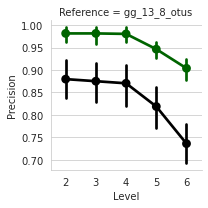

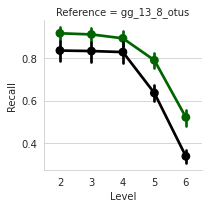

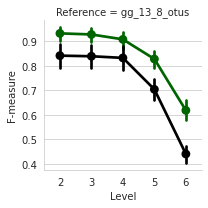

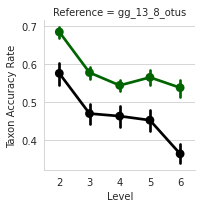

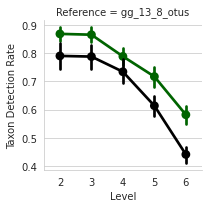

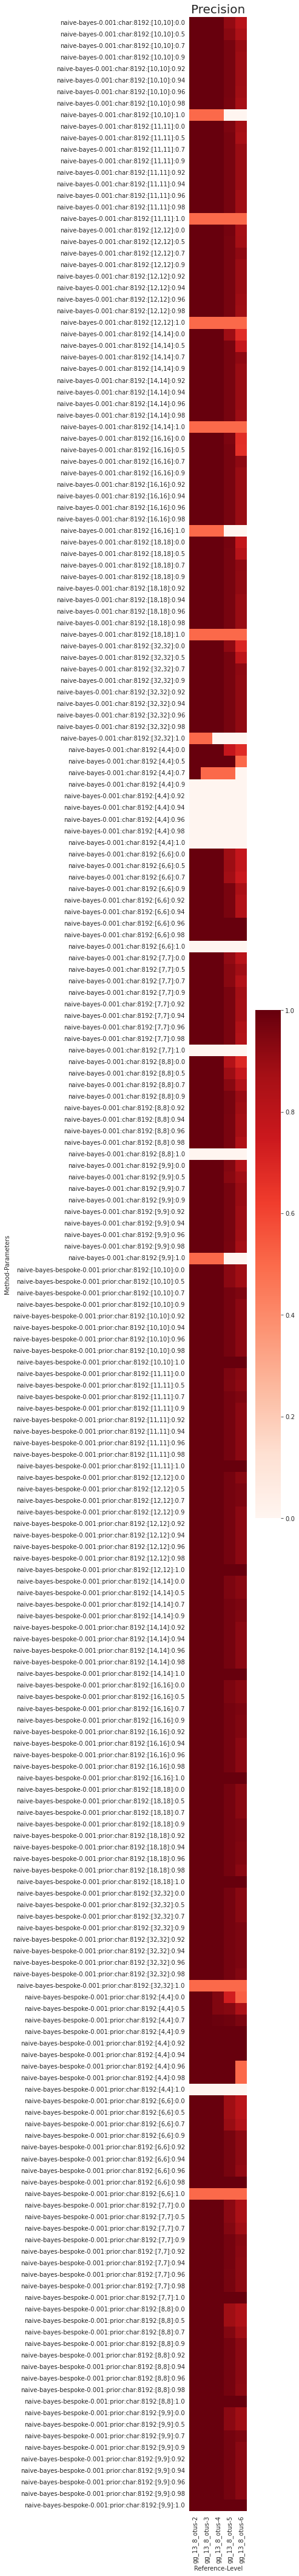

<Figure size 432x288 with 0 Axes>

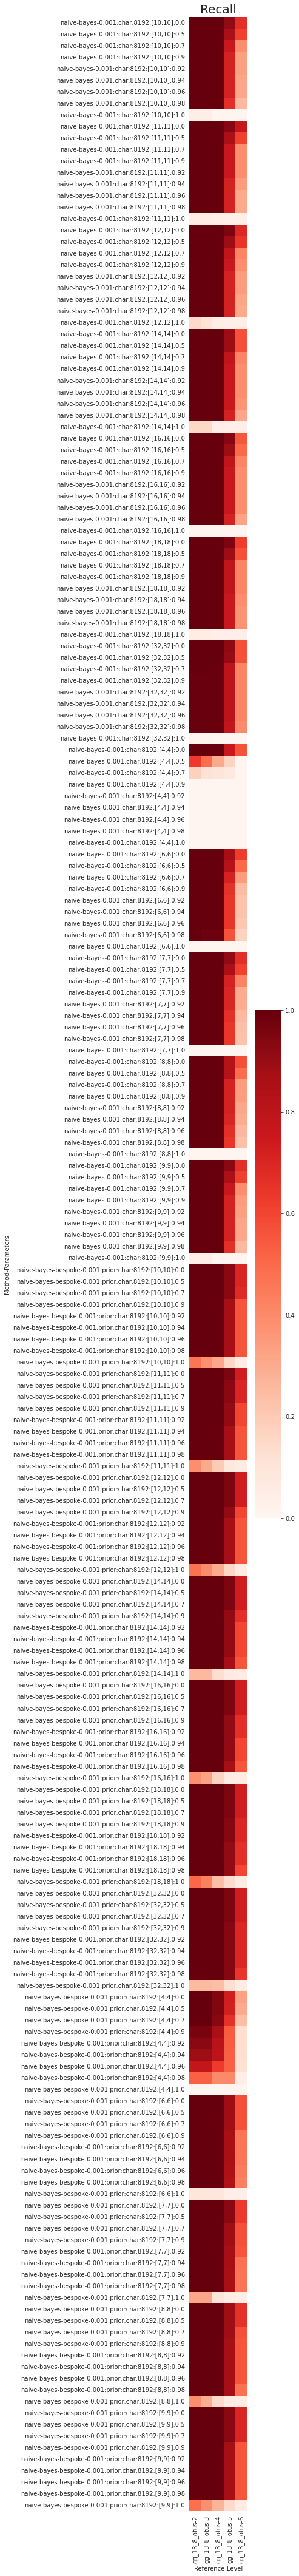

<Figure size 432x288 with 0 Axes>

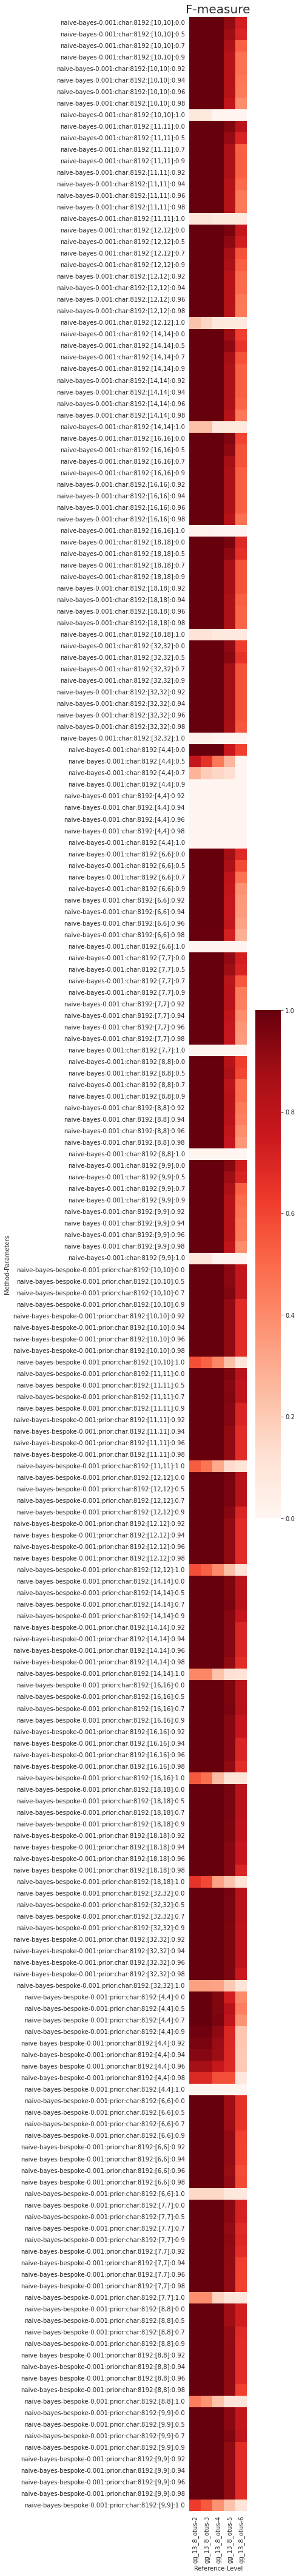

<Figure size 432x288 with 0 Axes>

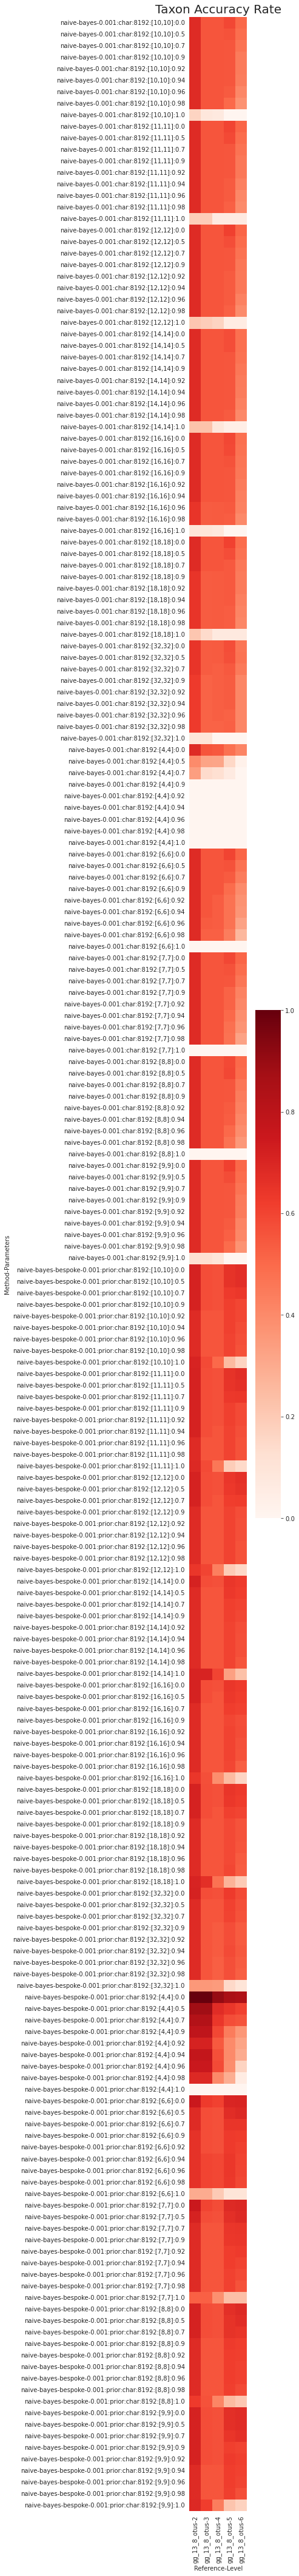

<Figure size 432x288 with 0 Axes>

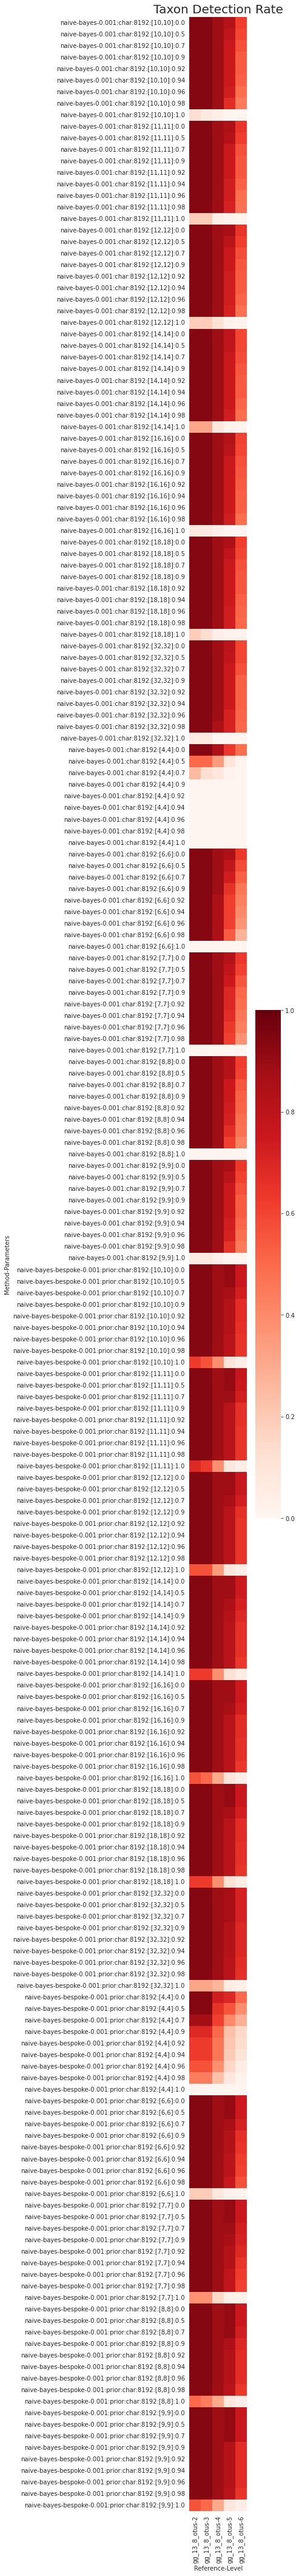

## mock-2

Method                         Parameters  Precision  \
4    naive-bayes-bespoke  0.001:prior:char:8192:[12,12]:0.7        1.0   
564          naive-bayes        0.001:char:8192:[14,14]:0.5        1.0   

       Recall  F-measure  Taxon Accuracy Rate  Taxon Detection Rate  
4    0.905037   0.950152             0.650000              0.702703  
564  0.862307   0.926063             0.545455              0.648649

## mock-1

Method                         Parameters  Precision  \
2124          naive-bayes        0.001:char:8192:[11,11]:0.0   0.801097   
1084  naive-bayes-bespoke  0.001:prior:char:8192:[12,12]:0.7   0.911128   

        Recall  F-measure  Taxon Accuracy Rate  Taxon Detection Rate  
2124  0.659208   0.723259             0.469388              0.621622  
1084  0.555923   0.690524             0.595745              0.756757

## naive-bayes-bespoke

Taxon Accuracy Rate  Taxon Detection Rate  \
0.001:prior:char:8192:[12,12]:0.7                  0.0                   2.0   
0.001:prior:char:8192:[18,18]:0.9                  0.0                   2.0   
0.001:prior:char:8192:[18,18]:0.5                  0.0                   2.0   
0.001:prior:char:8192:[16,16]:0.5                  0.0                   2.0   
0.001:prior:char:8192:[18,18]:0.7                  0.0                   2.0   

                                   Precision  Recall  F-measure  
0.001:prior:char:8192:[12,12]:0.7        2.0     2.0        2.0  
0.001:prior:char:8192:[18,18]:0.9        2.0     2.0        2.0  
0.001:prior:char:8192:[18,18]:0.5        1.0     2.0        2.0  
0.001:prior:char:8192:[16,16]:0.5        1.0     2.0        2.0  
0.001:prior:char:8192:[18,18]:0.7        1.0     2.0        2.0

## naive-bayes

Taxon Accuracy Rate  Taxon Detection Rate  \
0.001:char:8192:[12,12]:0.0                  2.0                   2.0   
0.001:char:8192:[11,11]:0.0                  2.0                   2.0   
0.001:char:8192:[18,18]:0.0                  2.0                   2.0   
0.001:char:8192:[6,6]:0.0                    2.0                   2.0   
0.001:char:8192:[9,9]:0.5                    2.0                   2.0   

                             Precision  Recall  F-measure  
0.001:char:8192:[12,12]:0.0        2.0     1.0        2.0  
0.001:char:8192:[11,11]:0.0        2.0     2.0        2.0  
0.001:char:8192:[18,18]:0.0        1.0     1.0        2.0  
0.001:char:8192:[6,6]:0.0          1.0     1.0        1.0  
0.001:char:8192:[9,9]:0.5          1.0     1.0        1.0

## Taxon Accuracy Rate

## gg_13_8_otus level 6

Method                       Parameters  Taxon Accuracy Rate  \
1  naive-bayes-bespoke  0.001:prior:char:8192:[4,4]:0.0             0.841615   
0          naive-bayes      0.001:char:8192:[11,11]:0.0             0.512472   

   Taxon Detection Rate  Precision    Recall  F-measure  
1              0.500000   0.526415  0.328158   0.401295  
0              0.648649   0.876942  0.760758   0.814275

stat         P     FDR P
Method A            Method B                                 
naive-bayes-bespoke naive-bayes  5.615643  0.112189  0.112189

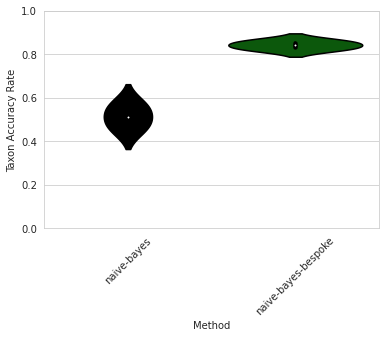

## Taxon Detection Rate

## gg_13_8_otus level 6

Method                         Parameters  \
1  naive-bayes-bespoke  0.001:prior:char:8192:[11,11]:0.0   
0          naive-bayes        0.001:char:8192:[12,12]:0.0   

   Taxon Accuracy Rate  Taxon Detection Rate  Precision    Recall  F-measure  
1             0.673611              0.770270   0.930988  0.730480   0.813035  
0             0.512472              0.648649   0.874630  0.694497   0.769684

stat         P     FDR P
Method A            Method B                             
naive-bayes-bespoke naive-bayes   9.0  0.070447  0.070447

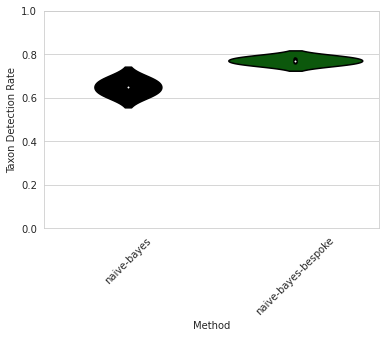

## Precision

## gg_13_8_otus level 6

Method                       Parameters  Taxon Accuracy Rate  \
0          naive-bayes       0.001:char:8192:[6,6]:0.98             0.259722   
1  naive-bayes-bespoke  0.001:prior:char:8192:[9,9]:1.0             0.174242   

   Taxon Detection Rate  Precision    Recall  F-measure  
0              0.270270        1.0  0.173493   0.284420  
1              0.040541        1.0  0.052638   0.095763

stat   P  FDR P
Method A            Method B                    
naive-bayes-bespoke naive-bayes   NaN NaN    NaN

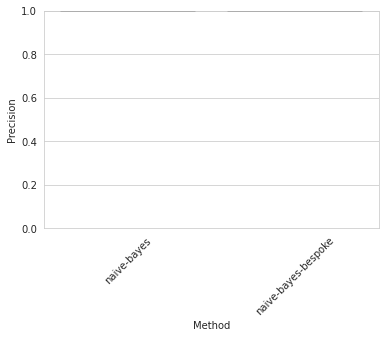

## Recall

## gg_13_8_otus level 6

Method                         Parameters  \
0          naive-bayes        0.001:char:8192:[11,11]:0.0   
1  naive-bayes-bespoke  0.001:prior:char:8192:[32,32]:0.0   

   Taxon Accuracy Rate  Taxon Detection Rate  Precision    Recall  F-measure  
0             0.512472              0.648649   0.876942  0.760758   0.814275  
1             0.583414              0.716216   0.930988  0.730480   0.813035

stat         P     FDR P
Method A            Method B                                 
naive-bayes-bespoke naive-bayes -0.414716  0.749727  0.749727

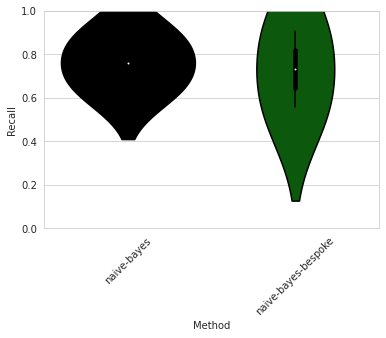

## F-measure

## gg_13_8_otus level 6

Method                         Parameters  \
1  naive-bayes-bespoke  0.001:prior:char:8192:[16,16]:0.7   
0          naive-bayes        0.001:char:8192:[11,11]:0.0   

   Taxon Accuracy Rate  Taxon Detection Rate  Precision    Recall  F-measure  
1             0.607432              0.729730   0.955564  0.730480   0.820338  
0             0.512472              0.648649   0.876942  0.760758   0.814275

stat        P    FDR P
Method A            Method B                              
naive-bayes-bespoke naive-bayes  0.15626  0.90132  0.90132

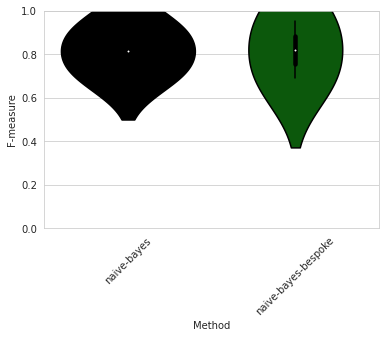

In [6]:
evaluate_method_accuracy('gg_13_8_otus','plots')